In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import itertools
from config import BIN_SIZE as bin_size

# 1. Loading of Dataframes

In [3]:
print(bin_size)
bin_size = 5000000
matrix_path = f"/labmed/workspace/lotta/finaletoolkit/dataframes_notebook/final_feature_matrix_gc_corrected_{bin_size}.tsv"
df = pd.read_csv(matrix_path, sep="\t")

clinical_path = "/labmed/workspace/lotta/finaletoolkit/dataframes_notebook/filtered_clinical_characteristics.csv"
clinical_df = pd.read_csv(clinical_path)

valid_samples = clinical_df["Extracted_ID"].unique()
df = df[df["sample"].isin(valid_samples)].copy()

print(f"Number of Samples in Matrix: {df['sample'].nunique()}")
print(f"Number of Bins per Sample: {len(df) / df['sample'].nunique()}")

50000
Number of Samples in Matrix: 247
Number of Bins per Sample: 411.0


# 2. Pipeline for LASSO

In [4]:
C_values = np.logspace(-2, 2, 50)
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('lasso_cv', LogisticRegressionCV(
        Cs=C_values,
        penalty='l1',
        solver='liblinear',
        cv=5,
        scoring='roc_auc',
        max_iter=10000,
        random_state=42
    ))
])

# 3. General Function for LASSO perfomance

In [5]:
def run_lasso_for_metrics(df, clinical_df, metrics, pipeline):
    # Pivot
    pivot_df = df.pivot(
        index="sample",
        columns="bin_id",
        values=list(metrics)
    )
    pivot_df.columns = [
        f"{metric}_{bin_id}" for metric, bin_id in pivot_df.columns
    ]

    # Labels
    y = []
    for sample_id in pivot_df.index:
        row = clinical_df[clinical_df["Extracted_ID"] == sample_id].iloc[0]
        y.append(0 if row["Patient Type"].lower() == "healthy" else 1)

    y = np.array(y)
    X = pivot_df


#Stratification
    y = []
    strata = []

    for sample_id in pivot_df.index:
        row = clinical_df[clinical_df["Extracted_ID"] == sample_id].iloc[0]
        
        is_healthy = row["Patient Type"].lower() == "healthy"
        y.append(0 if is_healthy else 1)
        strata.append(row["Gender"])

    y = np.array(y)
    X = pivot_df

    print(f"Number Cancer: {sum(y)}")
    print(f"Number Healthy: {len(y) - sum(y)}")

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.3,
        stratify=strata,
        random_state=42
    )

    # Fit
    pipeline.fit(X_train, y_train)

    # Predict
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_prob)

    # Koeffizienten
    lasso_model = pipeline.named_steps['lasso_cv']
    n_selected = np.sum(lasso_model.coef_[0] != 0)

    return {
        "metrics": metrics,
        "n_metrics": len(metrics),
        "n_features": X.shape[1],
        "n_selected_features": int(n_selected),
        "roc_auc": auc_score,
        "best_C": lasso_model.C_[0]
    }


# 4. Feature Selektion for LASSO (combinations of metrics)

In [6]:
df["bin_id"] = df["chrom"] + "_" + df["start"].astype(str)

metrics = [
    "mean_gc_corrected", 
    "median_gc_corrected", 
    "stdev_gc_corrected", 
    "wps_value_gc_corrected",
    "min_gc_corrected",
    "max_gc_corrected",	
]

metrics_results =[]

for r in range (1, len(metrics) + 1):
    for combination in itertools.combinations(metrics, r):
        res = run_lasso_for_metrics(df, clinical_df, combination, pipeline)
        metrics_results.append(res)

# nehme wps auf jeden fall mit rein 
metrics_with_wps = []
for metric in metrics_results:
    if "wps_value_gc_corrected" in metric['metrics']:
        metrics_with_wps.append(metric)
    else:
        #metrics_with_wps.append(metric) #mach ich nur um verschiedene kombis auch ohne wps zu testen 
        continue

metrics_with_wps = pd.DataFrame(metrics_with_wps).sort_values("roc_auc", ascending=False)
metrics_with_wps.to_csv("/labmed/workspace/lotta/finaletoolkit/dataframes_notebooklasso_metrics_results.csv", index=False)

print("10 Best metric combinations:")
print(metrics_with_wps.head(10))

best_metrics = metrics_with_wps.iloc[0]['metrics']
print("Best metrics:", best_metrics)

Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number

# 5. Influence of metric selection on model performance

<AxesSubplot:title={'center':'Mean ROC AUC vs Number of Metrics'}, xlabel='Number of Metrics', ylabel='ROC AUC'>

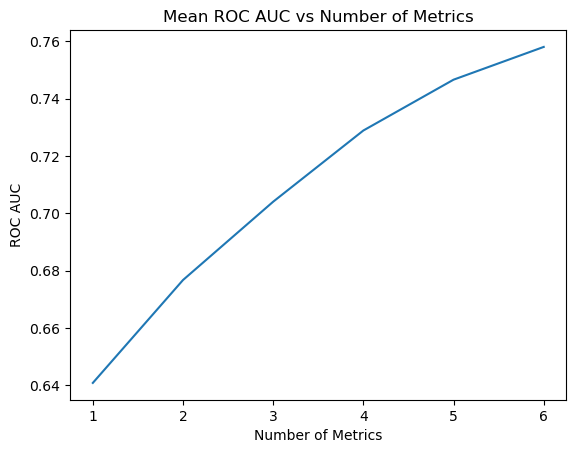

In [7]:
metrics_with_wps.groupby("n_metrics")["roc_auc"].mean().plot(
    title="Mean ROC AUC vs Number of Metrics",
    ylabel="ROC AUC",
    xlabel="Number of Metrics"
)

### 5.1 Lasso Modeling with best C parameter 

The `LogisticRegressionCV` model automatically tried out different values for the parameter `C`. 
Here we visualize how the accuracy of the model changes with `C`.

- **Small C**: Strong regularization (model is “forced” to find simple solutions). Risk of underfitting.
- **Large C**: Weak regularization (model can be more complex). Risk of overfitting.
- **Best C**: The value that achieved the best balance and thus the highest score in cross-validation (CV).

The Reciever operating characteristic curve plots the true positive (TP) rate versus the false positive (FP) rate at different classification thresholds. 

The thresholds are different probability cutoffs that separate the two classes in binary classification. It uses probability to tell us how well a model separates the classes.

Re-training model with best metrics: ('median_gc_corrected', 'wps_value_gc_corrected', 'min_gc_corrected', 'max_gc_corrected')


Confirmed ROC AUC on test set: 0.6667


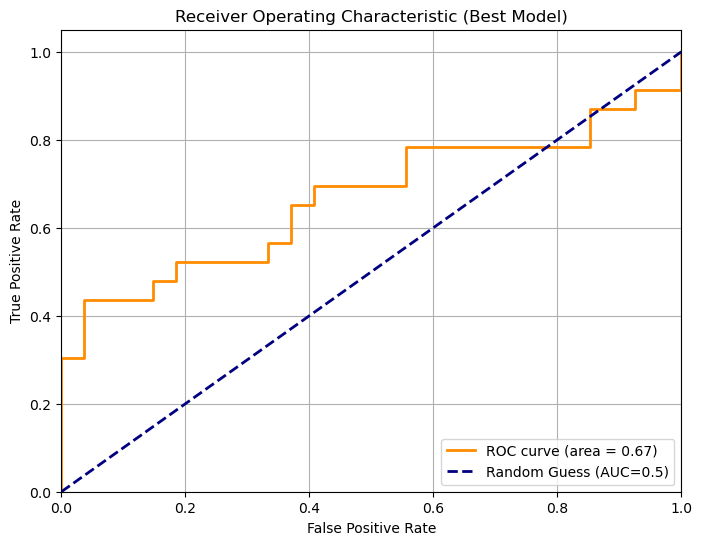

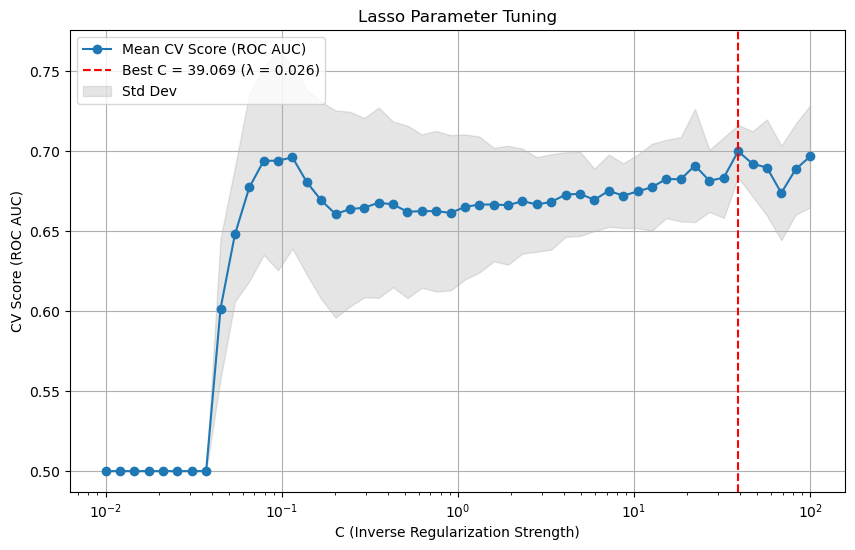

In [ ]:
print(f"Re-training model with best metrics: {best_metrics}")

# Pivot
pivot_df = df.pivot(
    index="sample",
    columns="bin_id",
    values=list(best_metrics)
)
pivot_df.columns = [
    f"{metric}_{bin_id}" for metric, bin_id in pivot_df.columns
]

# Labels
y = []
strata = []
for sample_id in pivot_df.index:
    row = clinical_df[clinical_df["Extracted_ID"] == sample_id].iloc[0]
    is_healthy = row["Patient Type"].lower() == "healthy"
    y.append(0 if is_healthy else 1)
    strata.append(row["Gender"])

y = np.array(y)
X = pivot_df

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=strata,
    random_state=42,
)

# Fit
pipeline.fit(X_train, y_train)

# Predict
# berechen wahrscheinlichkeiten für krebs [:,1] da gebraucht für ROC
y_prob = pipeline.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_prob)
print(f"Confirmed ROC AUC on test set: {auc_score:.4f}")

lasso_cv = pipeline.named_steps['lasso_cv']

# --- ROC Curve Plot ---
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--', label='Random Guess (AUC=0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Best Model)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#print(f"lasso cv scores: {lasso_cv.scores_}")
mean_scores = np.mean(lasso_cv.scores_[1], axis=0)
#print(f"mean scores: {mean_scores}")    
std_scores = np.std(lasso_cv.scores_[1], axis=0)
#print(f"std scores: {std_scores}")
cs = lasso_cv.Cs_
best_idx = np.argmax(mean_scores)
best_c = float(cs[best_idx])

# vcglmnet lamda.1se ( größtes lamda dessen score 1 se vom optimum liegt)
best_idx = np.argmax(mean_scores)
best_score = mean_scores[best_idx]
best_se = std_scores[best_idx]
threshold = best_score - best_se
c_1se = cs[np.where(mean_scores >= threshold)[0][0]]
#print(f"c_1se: {c_1se}, lambda_1se: {1/c_1se}")

# --- Lasso Parameter Tuning Plot ---
plt.figure(figsize=(10,6))
plt.semilogx(cs, mean_scores, marker='o', label='Mean CV Score (ROC AUC)')
plt.fill_between(cs, mean_scores - std_scores, mean_scores + std_scores, alpha=0.2, color='gray', label='Std Dev')
plt.axvline(best_c, linestyle='--', color='r', label=f'Best C = {best_c:.3f} (λ = {1/best_c:.3f})')
plt.title("Lasso Parameter Tuning")
plt.xlabel("C (Inverse Regularization Strength)")
plt.ylabel("CV Score (ROC AUC)")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
y_prob_train = pipeline.predict_proba(X_train)[:, 1]
y_prob_test = pipeline.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC (AUC = {auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'Test ROC (AUC = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.title('Training vs. Test ROC Performance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

NameError: name 'auc_train' is not defined

<Figure size 800x600 with 0 Axes>

## 5.2 Lasso Modeling with c_1se parameter 

In [ ]:
# --- STABILERES MODELL MIT C_1SE ---

# Wir nehmen die einfache LogisticRegression, da C jetzt feststeht
stable_lasso = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    C=c_1se,           # Dein berechneter stabiler Wert
    max_iter=10000,
    random_state=42
)

stable_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', stable_lasso) # Wir nennen den Schritt 'model'
])

stable_pipeline.fit(X_train, y_train)

# Vorhersage mit dem stabilen Modell
y_prob = stable_pipeline.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_prob)
print(f"Confirmed ROC AUC (1se Model) on test set: {auc_score:.4f}")

# --- ROC Curve Plot ---
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--', label='Random Guess (AUC=0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Stable 1se Model)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.semilogx(cs, mean_scores, marker='o', label='Mean CV Score (ROC AUC)')
plt.fill_between(cs, mean_scores - std_scores, mean_scores + std_scores, alpha=0.2, color='gray', label='Std Dev')
plt.axvline(c_1se, linestyle='--', color='r', label=f'Best C = {c_1se:.3f} (λ = {1/c_1se:.3f})')
plt.title("Lasso Parameter Tuning")
plt.xlabel("C (Inverse Regularization Strength)")
plt.ylabel("CV Score (ROC AUC)")
plt.legend()
plt.grid(True)
plt.show()

# --- Feature Analyse für das stabile Modell ---
# Wichtig: Der Schritt heißt jetzt 'model'
coef_stable = stable_pipeline.named_steps['model'].coef_[0]
n_features_stable = np.sum(coef_stable != 0)
print(f"Anzahl selektierter Features im stabilen Modell: {n_features_stable}")

NameError: name 'LogisticRegression' is not defined

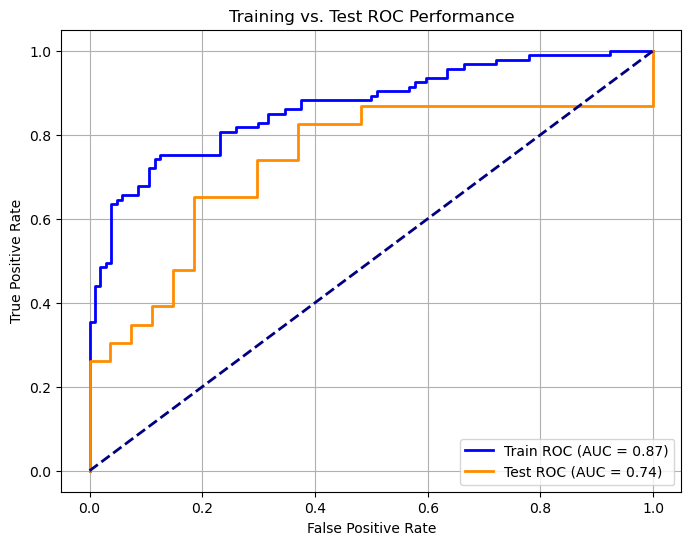

In [ ]:
y_prob_train = stable_pipeline.predict_proba(X_train)[:, 1]
y_prob_test = stable_pipeline.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC (AUC = {auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'Test ROC (AUC = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.title('Training vs. Test ROC Performance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 6. Selected Features by LASSO

In [ ]:
# 6. Selected Features
# Zugriff auf das LogisticRegressionCV-Modell in der Pipeline
#lasso_model = stable_pipeline.named_steps['model']
lasso_model = pipeline.named_steps['lasso_cv']


coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lasso_model.coef_[0]
})
# Filtere Features, die NICHT 0 sind
important_features = coef_df[coef_df["Coefficient"] != 0].sort_values(by="Coefficient", ascending=False)

print(f"Number of Important Features: {len(important_features)}")
print("\nTop Features (Positive = Indikative for Cancer, Negative = Indikative for Healthy):")
print(important_features.head(20))


Number of Important Features: 232

Top Features (Positive = Indikative for Cancer, Negative = Indikative for Healthy):
                                     Feature  Coefficient
572    wps_value_gc_corrected_chr1_195000000     0.945706
719    wps_value_gc_corrected_chr5_150000000     0.870950
739    wps_value_gc_corrected_chr6_115000000     0.854349
679      wps_value_gc_corrected_chr3_5000000     0.841476
753     wps_value_gc_corrected_chr6_45000000     0.786920
614    wps_value_gc_corrected_chr22_50000000     0.749662
763     wps_value_gc_corrected_chr7_10000000     0.679410
470    wps_value_gc_corrected_chr12_85000000     0.675239
428    wps_value_gc_corrected_chr10_75000000     0.657252
445    wps_value_gc_corrected_chr11_40000000     0.632722
464    wps_value_gc_corrected_chr12_55000000     0.575269
703     wps_value_gc_corrected_chr4_40000000     0.570005
1575          max_gc_corrected_chr6_45000000     0.547863
438   wps_value_gc_corrected_chr11_130000000     0.546429
544    wps_

## Visulaize the ROC Calculation (Label, Probability)

In [ ]:
# 1. Wahrscheinlichkeiten für das Test-Set holen
y_prob_test = pipeline.predict_proba(X_test)[:, 1]

# 2. DataFrame erstellen, um die Vorhersagen den Proben-IDs zuzuordnen
test_results = pd.DataFrame({
    'Sample_ID': X_test.index,
    'True_Label': y_test,
    'Probability_Cancer': y_prob_test
})

# 3. Nach Wahrscheinlichkeit sortieren (so "wandert" die ROC-Kurve)
test_results = test_results.sort_values(by='Probability_Cancer', ascending=False).reset_index(drop=True)

# 4. Anzeige der Tabelle
print("Detaillierte Vorhersagen für das Test-Set (sortiert nach Score):")
print(test_results)

# Optional: Speichern als CSV, um es in Excel genauer anzusehen
# test_results.to_csv("test_set_predictions_analysis.csv", index=False)

Detaillierte Vorhersagen für das Test-Set (sortiert nach Score):
   Sample_ID  True_Label  Probability_Cancer
0    EE87874           1        1.000000e+00
1    EE87873           1        9.999956e-01
2    EE88297           1        9.999890e-01
3    EE88299           1        9.999657e-01
4    EE87790           1        9.997475e-01
5    EE88295           1        9.994334e-01
6    EE88324           1        9.993987e-01
7    EE88019           0        9.993513e-01
8    EE87906           1        9.991199e-01
9    EE88296           1        9.988798e-01
10   EE87801           1        9.987677e-01
11   EE88030           0        9.982710e-01
12   EE88020           0        9.952331e-01
13   EE88029           0        9.868323e-01
14   EE87805           1        9.857032e-01
15   EE88028           0        9.830312e-01
16   EE87883           1        9.661406e-01
17   EE87993           0        9.626271e-01
18   EE85928           0        9.269081e-01
19   EE87960           0        9.1

In [ ]:
# Falsch-Negative (Krebs als gesund vorhergesagt)
fn_proben = test_results[(test_results['True_Label'] == 1) & (test_results['Probability_Cancer'] < 0.1)]

# Falsch-Positive (Gesund als Krebs vorhergesagt)
fp_proben = test_results[(test_results['True_Label'] == 0) & (test_results['Probability_Cancer'] > 0.9)]

# Jetzt mit klinischen Daten mergen
ausreisser_klinik = clinical_df[clinical_df['Extracted_ID'].isin(pd.concat([fn_proben['Sample_ID'], fp_proben['Sample_ID']]))]
print(ausreisser_klinik[['Extracted_ID', 'Patient Type', 'Gender']]) # Füge hier weitere Spalten wie Alter/Stadium hinzu

    Extracted_ID       Patient Type Gender
29       EE87952            Healthy      F
37       EE87960            Healthy      M
70       EE87993            Healthy      F
96       EE88019            Healthy      F
97       EE88020            Healthy      F
105      EE88028            Healthy      F
106      EE88029            Healthy      M
107      EE88030            Healthy      M
132      EE87809   Bile Duct Cancer      F
155      EE87886  Colorectal Cancer      M
167      EE87902     Gastric cancer      M
215      EE88320  Pancreatic Cancer      M
228      EE86270  Pancreatic Cancer      M
240      EE86270  Pancreatic Cancer      M
249      EE85928            Healthy      F
